In [29]:
# import os
# # from dotenv import load_dotenv
# from langchain_openai.chat_models import AzureChatOpenAI
# from langchain_openai.embeddings import AzureOpenAIEmbeddings

# load_dotenv()

# AZURE_OPENAI_API_KEY = os.environ['AZURE_OPENAI_API_KEY'] = os.getenv('AZURE_OPENAI_API_KEY')

# model = AzureChatOpenAI(
#     api_key=AZURE_OPENAI_API_KEY,
#     openai_api_version=os.getenv('AZURE_OPENAI_API_VERSION'),
#     azure_deployment=os.getenv('AZURE_OPENAI_DEPLOYMENT'),
#     openai_api_type='azure',
#     streaming=True
# )

In [1]:
# !pip install --upgrade langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 23.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
    Uninstalling langchain-0.3.12:
      Successfully uninstalled langchain-0.3.12


In [2]:
# ! pip install langgraph langchain_community langchain_openai chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.2/606.2 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.4 MB/s eta 0:00:00

In [8]:
import os
# from dotenv import load_dotenv
from langchain_openai.chat_models import AzureChatOpenAI
from langchain_openai.embeddings import AzureOpenAIEmbeddings

from google.colab import userdata
AZURE_OPENAI_API_KEY = os.environ['AZURE_OPENAI_API_KEY'] = userdata.get('AZURE_OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('TAVILY_API_KEY')

model = AzureChatOpenAI(
    api_key=AZURE_OPENAI_API_KEY,
    openai_api_version=userdata.get('AZURE_OPENAI_API_VERSION'),
    azure_deployment=userdata.get('AZURE_OPENAI_DEPLOYMENT'),
    azure_endpoint=userdata.get('AZURE_OPENAI_ENDPOINT'),
    openai_api_type='azure',
    streaming=True
)

In [9]:
embeddings = AzureOpenAIEmbeddings(
    azure_deployment=userdata.get("AZURE_EMBEDDING_DEPLOYMENT_MODEL"),
    azure_endpoint=userdata.get("AZURE_OPENAI_ENDPOINT"),
    openai_api_key=userdata.get("AZURE_OPENAI_API_KEY"),
)

In [10]:
model.invoke("hi").content

'Hello! How can I assist you today?'

Let's create Retriever

In [11]:
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(chunk_size=250, chunk_overlap=0)
doc_splitter = text_splitter.split_documents(doc_list)

vectorstore = Chroma.from_documents(
    documents=doc_splitter,
    collection_name="rag-chroma",
    embedding=embeddings
)

retriever = vectorstore.as_retriever()

Let's create a RAG chain

In [12]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

prompt = hub.pull("rlm/rag-prompt")

print(f"---PROMPT--- {prompt}")

def format_docs(docs):
  return "\n\n".join(doc.page_content for doc in docs)

rag_chain = prompt | model | StrOutputParser()

/usr/local/lib/python3.10/dist-packages/langsmith/client.py:261: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


---PROMPT--- input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


Let's test the RAG chain

In [13]:
question = "tell me about agent memory"
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In an LLM-powered autonomous agent system, memory is divided into short-term and long-term categories. Short-term memory involves in-context learning to retain and apply information within the current task. Long-term memory enables the agent to store and retrieve vast amounts of information over extended periods, typically using an external vector store for efficient access.


Let's create grade document class

In [14]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class GradeDocuments(BaseModel):
  """Binary score for relevance check on retrieved documents."""

  binary_score: str = Field(
      description = "Documents are relevant to the question, 'yes' or 'no'"
  )

In [15]:
# LLM with function call
structured_llm_grader = model.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
"""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n user question: {question}")
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [16]:
question = "tell me about the agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

<ipython-input-16-7c86fd261f06>:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='yes'


In [17]:
question = "tell me about the Taj Mahal"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


Let's create Question Re-Writer

In [18]:
from langchain_core.prompts import ChatPromptTemplate

system = """You are a question re-writer that converts an input question to a better version that is optimized \n
for web search. Look at the input and try to reason about the underlying semantic intent / meaning.
"""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human",
         "Here is the initial question: \n\n {question} \n Formulate an improved question."
         )
    ]
)

question_rewriter = re_write_prompt | model | StrOutputParser()

In [19]:
question = "tell me about agent memory"
question_rewriter.invoke({"question": question})

'What is agent memory and how does it work?'

Let's create a required function

In [21]:
def retrieve(state):
  """ Retrieve documents

  Args:
    state (dict): The current graph state
  """
  print("---RETRIEVE---")
  question = state['question']

  documents = retriever.get_relevant_documents(question)
  return {"documents": documents, "question": question}

In [22]:
def grade_documents(state):
  """Determines whether the retrieved documents are relevant to the question.

  Args:
    state (dict): The current graph state

    Returns:
      state (dict): The updated documents key with only filtered relevant documents
  """

  print("---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---")

  question = state['question']
  documents = state['documents']

  filtered_docs = []

  web_search = "No"

  for d in documents:
    score = retrieval_grader.invoke(
        {"question": question, "document": d.page_content}
    )
    grade = score.binary_score
    if grade == "yes":
      print("---GRADE: DOCUMENT RELEVANT---")
      filtered_docs.append(d)
    else:
      print("---GRADE: DOCUMENT NOT RELEVANT---")
      web_search = "Yes"
      continue

  return {"documents": filtered_docs, "question": question, "web_search": web_search}


In [23]:
def generate(state):
  """Generate answer

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): New key added to state, generation, that contains LLM generation
  """

  print("---GENERATE---")

  question = state['question']
  documents = state['documents']

  generation = rag_chain.invoke({"context": documents, "question": question})

  return {"documents": documents, "question": question, "generation": generation}

In [24]:
def transform_query(state):
  """Transform the query to produce a better result

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Updates question key with a re-phrased question
  """
  print("---TRANSFORM QUERY---")

  question = state['question']
  documents = state['documents']

  # re-write question
  better_question = question_rewriter.invoke({"question": question})
  return {"documents": documents, "question": better_question}

In [25]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

In [27]:
from langchain.schema import Document

def web_search(state):
  """
  Web search based on the re-phrased question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Updates documents key with appended web results
  """
  print("---WEB SEARCH---")

  question = state['question']
  documents = state['documents']

  docs = web_search_tool.invoke({"query": question})

  web_results = "\n".join([d['content'] for d in docs])

  web_results = Document(page_content=web_results)

  documents.append(web_results)

  return {"documents": documents, "question": question}

In [28]:
def decide_to_generate(state):
  """
  Determines whether to generate an answer, or re-generate a question.

  Args:
    state (dict): The current graph state

  Returns:
    state (dict): Binary decidion for next node to cell
  """
  print("---ASSESS GRADED DOCUMENTS---")
  state['question']
  web_search = state['web_search']
  state['documents']

  if web_search == 'Yes':
    # All documents have been filtered check_relevance
    # We will re-generate a new query
    print(
        "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY"
    )
    return "transform_query"
  else:
    print("---DECISION: GENERATE---")
    return "generate"

Let's create a skeleton of code then will create the function accordingly

In [37]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

class State(TypedDict):
  """
  Represents the state of our graph

  Attributes:
    question: question
    generation: LLM generation
    web_search: whether to add search
    documents: list of documents
  """
  question: str
  generation: str
  web_search: bool
  documents: list[str]


workflow = StateGraph(State)

In [38]:
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_document", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("transform_query", transform_query)
workflow.add_node("web_search_node", web_search)

In [39]:
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_document")
workflow.add_conditional_edges(
    "grade_document",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate"
    }
)

workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

In [40]:
app = workflow.compile()

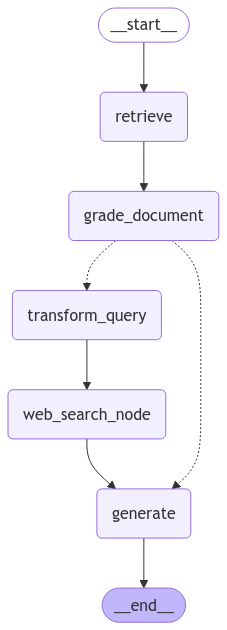

In [41]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [42]:
from pprint import pprint

inputs = {"question": "tell me about the agent memory."}

In [43]:
for output in app.stream(inputs):
  for key, value in output.items():
    pprint(f"None '{key}':")

  pprint("\n---\n")

pprint(value['generation'])

---RETRIEVE---
"None 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"None 'grade_document':"
'\n---\n'
---GENERATE---
"None 'generate':"
'\n---\n'
('Agent memory in LLM-powered autonomous systems is divided into short-term '
 'and long-term memory. Short-term memory involves in-context learning, while '
 'long-term memory allows the agent to retain and recall information over '
 'extended periods using an external vector store and fast retrieval. This '
 'enables the agent to learn from past experiences and improve future actions.')


In [44]:
inputs = {"question": "tell me about the TajMahal."}

In [45]:
for output in app.stream(inputs):
  for key, value in output.items():
    pprint(f"None '{key}':")

  pprint("\n---\n")

pprint(value['generation'])

---RETRIEVE---
"None 'retrieve':"
'\n---\n'
---CHECKING DOCUMENT RELEVANT IS TO QUESTION OR NOT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY
"None 'grade_document':"
'\n---\n'
---TRANSFORM QUERY---
"None 'transform_query':"
'\n---\n'
---WEB SEARCH---
"None 'web_search_node':"
'\n---\n'
---GENERATE---
"None 'generate':"
'\n---\n'
('The Taj Mahal is a world-famous mausoleum located in Agra, India, built by '
 'Mughal Emperor Shah Jahan in memory of his wife, Mumtaz Mahal, who died in '
 '1631. Constructed between 1631 and 1654, it is an iconic structure and a '
 'UNESCO World Heritage site, known for its stunning architecture and '
 'intricate designs using white marble and semi-precious stones. The Taj Mahal '
 'holds great historical and cultural significance and is visited by millions '
